<a href="https://colab.research.google.com/github/WoojinJeonkr/DeepLearning/blob/main/3D_image_classification_from_CT_scans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CT scan에서 3D 이미지 분류
- 내용 출처
1. [Computed Tomography (CT) Scan](https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/computed-tomography-ct-scan)
2. [3D image classification from CT scans](https://keras.io/examples/vision/3D_image_classification/)

## CT scan
- CT(Computed tomography): 컴퓨터 단층 촬영, X선과 컴퓨터 기술을 결합하여 신체 내부의 이미지를 생성하는 진단 영상 절차
- CT scan: 표준 엑스레이보다 상세, 표준 X선에서 연구 중인 신체 부위 겨냥, 신체 부위 뒤에 있는 판을 통과하며 일어나는 변화를 포착

## 01. 라이브러리 불러오기

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## 02. 데이터 다운로드
- 사용 데이터
1. 정상적인 CT 데이터: [normal CT scans](https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip)
2. 비정상적인 CT 데이터: [abnormal CT scans](https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip)

In [2]:
# 정상적인 CT 데이터 다운로드
# 다운받을 주소 정의
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
# 저장할 경로 정의
filename = os.path.join(os.getcwd(), "CT-0.zip")
# 파일 다운로드
keras.utils.get_file(filename, url)

'/content/CT-0.zip'

In [3]:
# 비정상적인 CT 데이터 다운로드
# 다운받을 주소 정의
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
# 파일 경로 정의
filename = os.path.join(os.getcwd(), "CT-23.zip")
# 파일 다운로드
keras.utils.get_file(filename, url)

'/content/CT-23.zip'

In [4]:
# 데이터를 저장할 폴더 생성
os.makedirs("MosMedData")

In [5]:
# 새로 생성한 폴더에 압축파일 해제
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

## 03. 데이터 불러오기 및 전처리
- 전처리 절차
1. 볼륨을 90도 회전하여 방향 고정
2. HU 값을 0과 1 사이로 조정
3. 너비, 높이 및 깊이의 크기 조정

In [6]:
import nibabel as nib
from scipy import ndimage

# 볼륨 불러오고 읽을 함수 정의
def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

# 볼륨 정규화 함수 정의
def normalize(volume):
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

# 이미지 크기 조정 함수 정의
def resize_volume(img):
    # 원하는 크기 설정
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    
    # 현재 크기 가져오기
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    # 깊이 요소 계산
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    
    # 회전
    img = ndimage.rotate(img, 90, reshape=False)
    
    # Z축에서 크기 조정
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

# 볼륨 크기 조정 및 읽는 함수 정의
def process_scan(path):
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [7]:
# 정상적인 scan 이미지 목록 가져오기
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]

# 비정상적인 scan 이미지 목록 가져오기
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

# 정상적인 폐 조직 CT scan 이미지 개수
print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
# 비정상적인 폐 조직 CT scan 이미지 개수
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


## 04.훈련/검증 데이터 분할

In [8]:
# 스캔 이미지 읽고 전처리
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# 훈련/검증 데이터 분할
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


## 05. 데이터 보강

In [9]:
import random
from scipy import ndimage

@tf.function
def rotate(volume):
    def scipy_rotate(volume):
        # 회전 각도 정의
        angles = [-20, -10, -5, 5, 10, 20]
        # angles에서 랜덤으로 선택
        angle = random.choice(angles)
        # 볼륨 회전
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

# 훈련 데이터 회전하는 함수 정의
def train_preprocessing(volume, label):
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

# 검증 데이터 회전하는 함수 정의
def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [10]:
# data loader 정의
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [11]:
# 배치 사이즈 정의
batch_size = 2

train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 64, 1)


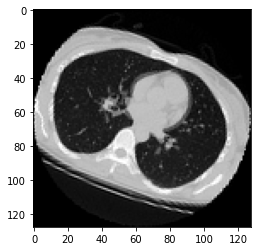

In [12]:
# CT scan 시각화
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

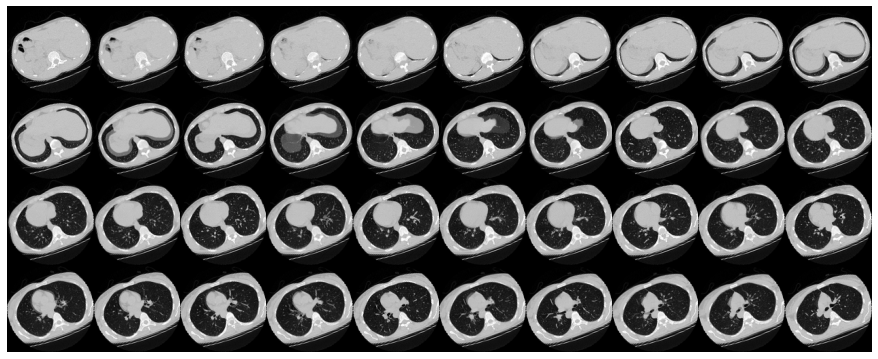

In [13]:
# CT scan 시각화 함수 정의
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

# 시각화
plot_slices(4, 10, 128, 128, image[:, :, :40])

## 06. 3D Convolutional 신경망 정의

In [14]:
# 모델 정의
def get_model(width=128, height=128, depth=64):

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

# 모델 생성
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

## 07. 훈련 모델

In [15]:
# 모델 컴파일
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

In [16]:
# callback 정의
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [17]:
# 모델 훈련
epochs = 10
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
70/70 - 1669s - loss: 0.6898 - acc: 0.6286 - val_loss: 0.9140 - val_acc: 0.5000 - 1669s/epoch - 24s/step
Epoch 2/10
70/70 - 1650s - loss: 0.6763 - acc: 0.5929 - val_loss: 1.6265 - val_acc: 0.5000 - 1650s/epoch - 24s/step
Epoch 3/10
70/70 - 1643s - loss: 0.6627 - acc: 0.6000 - val_loss: 1.1459 - val_acc: 0.5000 - 1643s/epoch - 23s/step
Epoch 4/10
70/70 - 1648s - loss: 0.6561 - acc: 0.5929 - val_loss: 0.8347 - val_acc: 0.5000 - 1648s/epoch - 24s/step
Epoch 5/10
70/70 - 1647s - loss: 0.6469 - acc: 0.6500 - val_loss: 1.4350 - val_acc: 0.5000 - 1647s/epoch - 24s/step
Epoch 6/10
70/70 - 1647s - loss: 0.6472 - acc: 0.6071 - val_loss: 1.8932 - val_acc: 0.5000 - 1647s/epoch - 24s/step
Epoch 7/10
70/70 - 1648s - loss: 0.6099 - acc: 0.6714 - val_loss: 0.7783 - val_acc: 0.5000 - 1648s/epoch - 24s/step
Epoch 8/10
70/70 - 1656s - loss: 0.5975 - acc: 0.6214 - val_loss: 0.9511 - val_acc: 0.5000 - 1656s/epoch - 24s/step
Epoch 9/10
70/70 - 1655s - loss: 0.5943 - acc: 0.6429 - val_loss: 0.7755

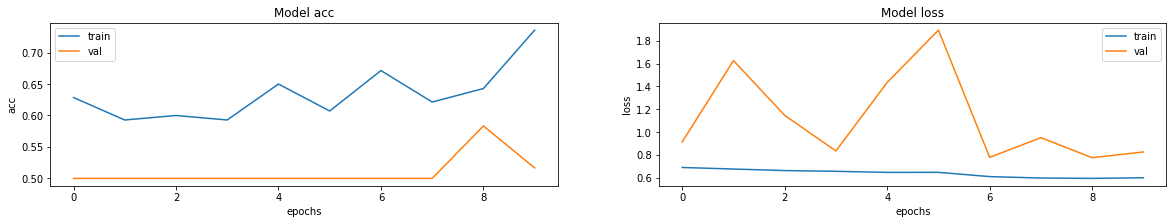

In [18]:
# 모델 성능 시각화
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])